# Market Learning
*Leveraging machine learning to help you learn the market and invest your money*

### Objective
The Market Learning project is intended to provide an adaptive, fact-based introduction of the stock markets to a user with limited experience with personal investment decisions. This presentation is for people who are interested in understanding the stock market but don't want to spend much time worrying about it and any investments they have in it. 

This report does not offer investment advice, as individuals must be completely responsible for their financial choices. This report offers the author's analyses and opinions which seek to offer educational value.

### Outline
- Data Collection
- Data Cleaning
- Visualization
- Prediction
- Conclusion

**Introduction**

The stock market is made of organized exchanges, like New York Stock Exchange and Nasdaq. 
The exchanges function as markets for the stocks listed on them, letting people buy and sell shares of stocks.
Most people need to use an intermediary broker to actually trade on an exchange. 
(definition of stocks)
(mention other security types)

In [156]:
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from enum import Enum

### Data Collection

First, I scrape a list of names and acronyms of 11,000+ stocks and other securities from Nasdaq. 

In [149]:
nasdaq_url = 'http://www.nasdaqtrader.com/dynamic/SymDir/nasdaqtraded.txt'
page_data = pd.read_csv(nasdaq_url, sep='|')
page_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11505 entries, 0 to 11504
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     11505 non-null  object 
 1   Symbol            11503 non-null  object 
 2   Security Name     11504 non-null  object 
 3   Listing Exchange  11504 non-null  object 
 4   Market Category   11504 non-null  object 
 5   ETF               11504 non-null  object 
 6   Round Lot Size    11504 non-null  float64
 7   Test Issue        11504 non-null  object 
 8   Financial Status  5287 non-null   object 
 9   CQS Symbol        6217 non-null   object 
 10  NASDAQ Symbol     11503 non-null  object 
 11  NextShares        11504 non-null  object 
dtypes: float64(1), object(11)
memory usage: 1.1+ MB


Then I clean this data to isolate the acronyms, which are all I will use. 

In [151]:
page_data.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAA,Investment Managers Series Trust II AXS First ...,P,,Y,100.0,N,NaN,AAA,AAA,N
3,Y,AAAU,Goldman Sachs Physical Gold ETF Shares,Z,,Y,100.0,N,NaN,AAAU,AAAU,N
4,Y,AAC,Ares Acquisition Corporation Class A Ordinary ...,N,,N,100.0,N,NaN,AAC,AAC,N


In [152]:
# Is Financial Status informative?
page_data['Financial Status'].value_counts()

Financial Status
N    4594
D     612
E      56
H      25
Name: count, dtype: int64

In [153]:
# Check if the "Test Issue" column is a useful warning
page_data['Test Issue'].value_counts() # only 'Y' and 'N'
# Find the rows where 'Test Issue' == 'Y'
page_data[page_data['Test Issue'] == 'Y']
# Find out if yFinance can get these stocks
yf.Ticker('CBO').info # yes
yf.Ticker('CBX').info # yes 
# So, I will ignore the 'Test Issue' column for now

{'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 25.0,
 'open': 25.0,
 'regularMarketPreviousClose': 25.0,
 'regularMarketOpen': 25.0,
 'bid': 17.5,
 'ask': 32.5,
 'currency': 'USD',
 'exchange': 'NYQ',
 'quoteType': 'EQUITY',
 'symbol': 'CBX',
 'underlyingSymbol': 'CBX',
 'timeZoneFullName': 'America/New_York',
 'timeZoneShortName': 'EDT',
 'gmtOffSetMilliseconds': -14400000,
 'trailingPegRatio': None}

In [154]:
# Look for null values
page_data[page_data['Symbol'].isna()]
# There are only 2 rows with null symbols, and I can remove them both. 
page_data = page_data[page_data['Symbol'].notna()]
page_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11503 entries, 0 to 11503
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     11503 non-null  object 
 1   Symbol            11503 non-null  object 
 2   Security Name     11503 non-null  object 
 3   Listing Exchange  11503 non-null  object 
 4   Market Category   11503 non-null  object 
 5   ETF               11503 non-null  object 
 6   Round Lot Size    11503 non-null  float64
 7   Test Issue        11503 non-null  object 
 8   Financial Status  5286 non-null   object 
 9   CQS Symbol        6217 non-null   object 
 10  NASDAQ Symbol     11503 non-null  object 
 11  NextShares        11503 non-null  object 
dtypes: float64(1), object(11)
memory usage: 1.1+ MB


In [155]:
# Save just the data I want: the acronyms
# Override the variable page_data with just a series of the symbols - may improve memory use
page_data = page_data['Symbol']
page_data.info()

<class 'pandas.core.series.Series'>
Index: 11503 entries, 0 to 11503
Series name: Symbol
Non-Null Count  Dtype 
--------------  ----- 
11503 non-null  object
dtypes: object(1)
memory usage: 179.7+ KB


I use the yfinance library to instantiate a Ticker object from my list of acronyms. yfinance uses Yahoo Finance's API to get financial data. This cell doesn't immediately give me a dataset of security financial history, but it instantiates a yfinance Ticker object where I can get that. I could directly use yfinance's .download() method to get a dataset, but the format of that dataframe seems less efficient than this.

Information on yfinance is available at: 'https://pypi.org/project/yfinance/'.

In [53]:
ticker_objects = yf.Tickers(' '.join(page_data.tolist()))
len(ticker_objects.tickers)  # 11,511 ticker objects
# ticker_objects.tickers['ZYXI'].info # make sure it got all the stocks

# df_master = yf.download(page_data.tolist(), period='max') # the df seems inefficient
# df_master.info()

{'address1': '9655 Maroon Circle',
 'city': 'Englewood',
 'state': 'CO',
 'zip': '80112',
 'country': 'United States',
 'phone': '303 703 4906',
 'fax': '800 495 6695',
 'website': 'https://www.zynex.com',
 'industry': 'Medical Distribution',
 'sector': 'Healthcare',
 'longBusinessSummary': 'Zynex, Inc., together with its subsidiaries, designs, manufactures, and markets medical devices to treat chronic and acute pain; and activate and exercise muscles for rehabilitative purposes with electrical stimulation. The company offers NexWave, a dual channel, multi-modality interferential current, transcutaneous electrical nerve stimulation, and neuromuscular electrical stimulation (NMES) device that is marketed to physicians and therapists by field sales representatives; NeuroMove, an electromyography and electric stimulation technology device; InWave, an electrical stimulation product for the treatment of female urinary incontinence; and E-Wave, an NMES device. It also supplies private labele

Then I explore one Ticker object to understand what I received from yfinance, and to see what it gives for financial data with the .history() method.

In [54]:
ticker_objects.tickers['AAPL'].info
# ticker_objects.tickers['AAPL'].recommendations

# Get the history of one stock
df_aapl = ticker_objects.tickers['AAPL'].history(period='max', repair=False)
df_aapl.info(), df_aapl.head()

I need to clean the data a little bit to make sure my dataframe contains the security type and acronym

In [ ]:
# Mark the company's data with the security type, acronym/name, and other info
df_aapl['security_type'] = ticker_objects.tickers['AAPL'].info['quoteType']
df_aapl['acronym'] = ticker_objects.tickers['AAPL'].info['symbol']
df_aapl.info(), df_aapl.head()

This approach is limiting my memory use and performance, so instead I'll directly define integers to represent different security classifications, instead of strings. I know that some ML algorithms do this, and others like target encoding prefer to see the whole dataset before prescribing numbers for classifications, so they can be a little smarter about it. I may need to revisit this later.

In [55]:
class SecurityType(Enum):
    EQUITY = 1
    ETF = 2
    MUTUALFUND = 3
    INDEX = 4
    CURRENCY = 5
    FUTURE = 6
    CRYPTO = 7

Finally, I download the financial data for all of my securities. I clean each security's data while downloading it to improve memory use and performance. 

In [57]:
# estimate 1.5 hours to run this cell
# Repeat this process for all tickers
lst_dfs = []
for ticker in ticker_objects.tickers:
    # Download the data for each ticker
    df = ticker_objects.tickers[ticker].history(period='max', repair=True)
    
    # If yahoo api throws an error, skip this ticker
    if df.empty:
        # I could also remove it from the list of acronyms if that's useful
        continue

    # Add the ticker's major info to the dataframe
    df['Security Type'] = SecurityType[ticker_objects.tickers[ticker].info['quoteType']].value
    df['Security Type'] = df['Security Type'].astype('int16')
    df['Acronym'] = ticker # ticker_objects.tickers[ticker].info['symbol']
    df['Acronym'] = df['Acronym'].astype('string') # I don't think this actually improved memory usage
#     df['Exchange'] = ticker_objects.tickers[ticker].info['exchange']
#     df['Industry'] = ticker_objects.tickers[ticker].info['industry']
#     df['Sector'] = ticker_objects.tickers[ticker].info['sector']

    # # Not all the dataframes have the Capital Gains column, so I need to add it before removing it
    # if 'Capital Gains' not in df.columns:
    #     df['Capital Gains'] = np.nan

    # Remove unnecessary columns
    df.drop(columns=['Open', 'High', 'Low'], inplace=True, axis=1)

    lst_dfs.append(df)
df_all = pd.concat(lst_dfs)

df_all.info(), df_all.head()

Got error from yahoo api for ticker AAC.U, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AAC.U: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AAC.W, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AAC.W: No timezone found, symbol may be delisted
AACIW: 1d data not available for startTime=-2208994789 and endTime=1683084445. Only 100 years worth of day granularity data are allowed to be fetched per request.
Got error from yahoo api for ticker AACT.U, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AACT.U: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AAIC$B, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AAIC$B: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AAIC$C, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be

(None,
                                Close    Volume  Dividends  Stock Splits   
 Date                                                                      
 1999-11-18 00:00:00-05:00  26.845926  62546380        0.0           0.0  \
 1999-11-19 00:00:00-05:00  24.634188  15234146        0.0           0.0   
 1999-11-22 00:00:00-05:00  26.845926   6577870        0.0           0.0   
 1999-11-23 00:00:00-05:00  24.405388   5975611        0.0           0.0   
 1999-11-24 00:00:00-05:00  25.053656   4843231        0.0           0.0   
 
                            Security Type Acronym  Capital Gains  
 Date                                                             
 1999-11-18 00:00:00-05:00              1       A            NaN  
 1999-11-19 00:00:00-05:00              1       A            NaN  
 1999-11-22 00:00:00-05:00              1       A            NaN  
 1999-11-23 00:00:00-05:00              1       A            NaN  
 1999-11-24 00:00:00-05:00              1       A        

### Data Cleaning
First, I check for null values

In [59]:
df_all.info(), df_all.head()

# Look for null values
df_all.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31209493 entries, 1999-11-18 00:00:00-05:00 to 2023-05-02 00:00:00-04:00
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Close          float64
 1   Volume         int64  
 2   Dividends      float64
 3   Stock Splits   float64
 4   Security Type  int16  
 5   Acronym        string 
 6   Capital Gains  float64
dtypes: float64(4), int16(1), int64(1), string(1)
memory usage: 1.7 GB


Close                   1
Volume                  0
Dividends               0
Stock Splits            0
Security Type           0
Acronym                 0
Capital Gains    25660098
dtype: int64

In [77]:
df_all['Capital Gains'].value_counts() # useless
df_all.drop(columns=['Capital Gains'], inplace=True, axis=1)
df_all.head(), df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31209493 entries, 1999-11-18 00:00:00-05:00 to 2023-05-02 00:00:00-04:00
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Close          float64
 1   Volume         int64  
 2   Dividends      float64
 3   Stock Splits   float64
 4   Security Type  int16  
 5   Acronym        string 
dtypes: float64(3), int16(1), int64(1), string(1)
memory usage: 1.5 GB


(                               Close    Volume  Dividends  Stock Splits   
 Date                                                                      
 1999-11-18 00:00:00-05:00  26.845926  62546380        0.0           0.0  \
 1999-11-19 00:00:00-05:00  24.634188  15234146        0.0           0.0   
 1999-11-22 00:00:00-05:00  26.845926   6577870        0.0           0.0   
 1999-11-23 00:00:00-05:00  24.405388   5975611        0.0           0.0   
 1999-11-24 00:00:00-05:00  25.053656   4843231        0.0           0.0   
 
                            Security Type Acronym  
 Date                                              
 1999-11-18 00:00:00-05:00              1       A  
 1999-11-19 00:00:00-05:00              1       A  
 1999-11-22 00:00:00-05:00              1       A  
 1999-11-23 00:00:00-05:00              1       A  
 1999-11-24 00:00:00-05:00              1       A  ,
 None)

What is the Stock Splits?

In [60]:
df_all['Stock Splits'].value_counts()

Stock Splits
0.000    31201883
2.000        2177
1.500        1100
1.050         524
1.100         393
           ...   
1.321           1
2.865           1
0.675           1
1.195           1
3.207           1
Name: count, Length: 484, dtype: int64

In [61]:
df_all[df_all['Stock Splits'] != 0]

,Close,Volume,Dividends,Stock Splits,Security Type,Acronym,Capital Gains
Date,,,,,,,
2014-11-03 00:00:00-05:00,37.991936,4559800,0.0,1.398,1,A,NaN
1974-02-04 00:00:00-04:00,2.074766,536663,0.0,1.500,1,AA,NaN
1981-02-23 00:00:00-05:00,3.959314,92884,0.0,2.000,1,AA,NaN
1995-02-27 00:00:00-05:00,16.188967,812484,0.0,2.000,1,AA,NaN
1999-02-26 00:00:00-05:00,35.380581,758136,0.0,2.000,1,AA,NaN
...,...,...,...,...,...,...,...
2012-05-11 00:00:00-04:00,128.820007,313350,0.0,0.200,2,ZSL,0.0
2015-11-13 00:00:00-05:00,247.080002,9900,0.0,2.000,2,ZSL,0.0
2021-05-26 00:00:00-04:00,21.180000,389300,0.0,0.250,2,ZSL,0.0


I want to have a normal index instead of the Date Index.

In [118]:
df_all.index
# df_all['Date'] = df_all.index # this was a mistake
df_all.head()
df_all.info()
# df_all.reset_index(inplace=True) # this doesn't work now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31209493 entries, 0 to 31209492
Data columns (total 5 columns):
 #   Column         Dtype                           
---  ------         -----                           
 0   Date           datetime64[ns, America/New_York]
 1   Close          float64                         
 2   Dividends      float64                         
 3   Security Type  int16                           
 4   Acronym        string                          
dtypes: datetime64[ns, America/New_York](1), float64(2), int16(1), string(1)
memory usage: 1012.0 MB


In [91]:
# df_all = df_all.reset_index() # still doesn't work, because of that mistake
df_all.head()
# df_all.drop(columns=['Date'], inplace=True)

In [95]:
df_all.head()
df_all.reset_index() # this looks good
df_all.reset_index(inplace=True)

In [120]:
df_all['Date']

0          1999-11-18 00:00:00-05:00
1          1999-11-19 00:00:00-05:00
2          1999-11-22 00:00:00-05:00
3          1999-11-23 00:00:00-05:00
4          1999-11-24 00:00:00-05:00
                      ...           
31209488   2023-04-26 00:00:00-04:00
31209489   2023-04-27 00:00:00-04:00
31209490   2023-04-28 00:00:00-04:00
31209491   2023-05-01 00:00:00-04:00
31209492   2023-05-02 00:00:00-04:00
Name: Date, Length: 31209493, dtype: datetime64[ns, America/New_York]

In [100]:
df_all[df_all['Stock Splits'] != 0]
df_all[3762-10:3762+10]

,Date,Close,Volume,Dividends,Stock Splits,Security Type,Acronym
3752,2014-10-20 00:00:00-04:00,34.834961,6909196,0.0,0.000,1,A
3753,2014-10-21 00:00:00-04:00,35.932903,3120196,0.0,0.000,1,A
3754,2014-10-22 00:00:00-04:00,35.300758,3021218,0.0,0.000,1,A
3755,2014-10-23 00:00:00-04:00,35.739937,2453071,0.0,0.000,1,A
3756,2014-10-24 00:00:00-04:00,35.966179,2108464,0.0,0.000,1,A
3757,2014-10-27 00:00:00-04:00,35.926258,1545209,0.0,0.000,1,A
3758,2014-10-28 00:00:00-04:00,36.372082,2394774,0.0,0.000,1,A
3759,2014-10-29 00:00:00-04:00,36.265621,2074213,0.0,0.000,1,A
3760,2014-10-30 00:00:00-04:00,36.145836,2883794,0.0,0.000,1,A
3761,2014-10-31 00:00:00-04:00,36.784649,2918744,0.0,0.000,1,A


Volume of a stock is "the amount of an asset or security that changes hands over some period of time, often over the course of a day" (investopedia.com). It's said to be useful for indicating the significance of daily price moves. 

I'm removing Volume, along with the other day-to-day indicators like High and Low, in an attempt to find more long-term patterns that are useful for investing. However it's possible that actively "playing the stock market game" on a day-to-day level is an effective strategy, and I may revisit it at a later time. 

In [101]:
df_all.drop(columns=['Volume'], inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31209493 entries, 0 to 31209492
Data columns (total 6 columns):
 #   Column         Dtype                           
---  ------         -----                           
 0   Date           datetime64[ns, America/New_York]
 1   Close          float64                         
 2   Dividends      float64                         
 3   Stock Splits   float64                         
 4   Security Type  int16                           
 5   Acronym        string                          
dtypes: datetime64[ns, America/New_York](1), float64(3), int16(1), string(1)
memory usage: 1.2 GB


In [110]:
i = 15254
df_all[df_all['Stock Splits'] != 0]
df_all[i-5:i+5]

,Date,Close,Dividends,Stock Splits,Security Type,Acronym
15249,1999-02-19 00:00:00-05:00,36.254177,0.0,0.0,1,AA
15250,1999-02-22 00:00:00-05:00,36.336056,0.0,0.0,1,AA
15251,1999-02-23 00:00:00-05:00,36.144966,0.0,0.0,1,AA
15252,1999-02-24 00:00:00-05:00,36.254177,0.0,0.0,1,AA
15253,1999-02-25 00:00:00-05:00,35.899254,0.0,0.0,1,AA
15254,1999-02-26 00:00:00-05:00,35.380581,0.0,2.0,1,AA
15255,1999-03-01 00:00:00-05:00,36.144966,0.0,0.0,1,AA
15256,1999-03-02 00:00:00-05:00,34.616180,0.0,0.0,1,AA
15257,1999-03-03 00:00:00-05:00,33.851788,0.0,0.0,1,AA
15258,1999-03-04 00:00:00-05:00,34.179371,0.0,0.0,1,AA


Stock Splits happen when "a company issues additional shares to shareholders, increasing the total by the specified ratio based on the shares they held previously" (investopedia). They're said to split the price of each share as well, so that the overall market cap doesn't change. However the closing prices are not changing by a factor of 2 in my data, so I'm going to remove this as well. 

In [111]:
df_all.drop(columns=['Stock Splits'], inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31209493 entries, 0 to 31209492
Data columns (total 5 columns):
 #   Column         Dtype                           
---  ------         -----                           
 0   Date           datetime64[ns, America/New_York]
 1   Close          float64                         
 2   Dividends      float64                         
 3   Security Type  int16                           
 4   Acronym        string                          
dtypes: datetime64[ns, America/New_York](1), float64(2), int16(1), string(1)
memory usage: 1012.0 MB


In [112]:
df_all.index, df_all['Acronym'][0], df_all[0:4]

(RangeIndex(start=0, stop=31209493, step=1),
 'A',
                        Date      Close  Dividends  Security Type Acronym
 0 1999-11-18 00:00:00-05:00  26.845926        0.0              1       A
 1 1999-11-19 00:00:00-05:00  24.634188        0.0              1       A
 2 1999-11-22 00:00:00-05:00  26.845926        0.0              1       A
 3 1999-11-23 00:00:00-05:00  24.405388        0.0              1       A)

I'm exporting this data to a CSV file so I don't have to repeat this process as I work on this project. 

In [113]:
# export the dataframe to a csv in the repo folder
df_all.to_csv('market_data.csv')

In [117]:
i = 1748
df_all[df_all['Dividends'] != 0] 
# df_all[i-5:i+5]

,Date,Close,Dividends,Security Type,Acronym
1748,2006-11-01 00:00:00-05:00,22.075010,1.471388,1,A
3110,2012-03-30 00:00:00-04:00,28.887463,0.071531,1,A
3173,2012-06-29 00:00:00-04:00,25.534868,0.071531,1,A
3236,2012-09-28 00:00:00-04:00,25.085817,0.071531,1,A
3296,2012-12-27 00:00:00-05:00,26.579636,0.071531,1,A
...,...,...,...,...,...
31189349,2021-07-20 00:00:00-04:00,199.550827,0.250000,1,ZTS
31189420,2021-10-28 00:00:00-04:00,212.329010,0.250000,1,ZTS
31189476,2022-01-19 00:00:00-05:00,200.580002,0.325000,1,ZTS
31207258,2014-06-17 00:00:00-04:00,0.308937,0.150000,1,ZYXI


Dividends are where companies actually pay shareholders in some way, like through more shares or cash. That could be an important aspect for investment

In [136]:
df_all['Security Type'].value_counts()

Security Type
1    25660098
2     5549395
Name: count, dtype: int64

### Data Visualization

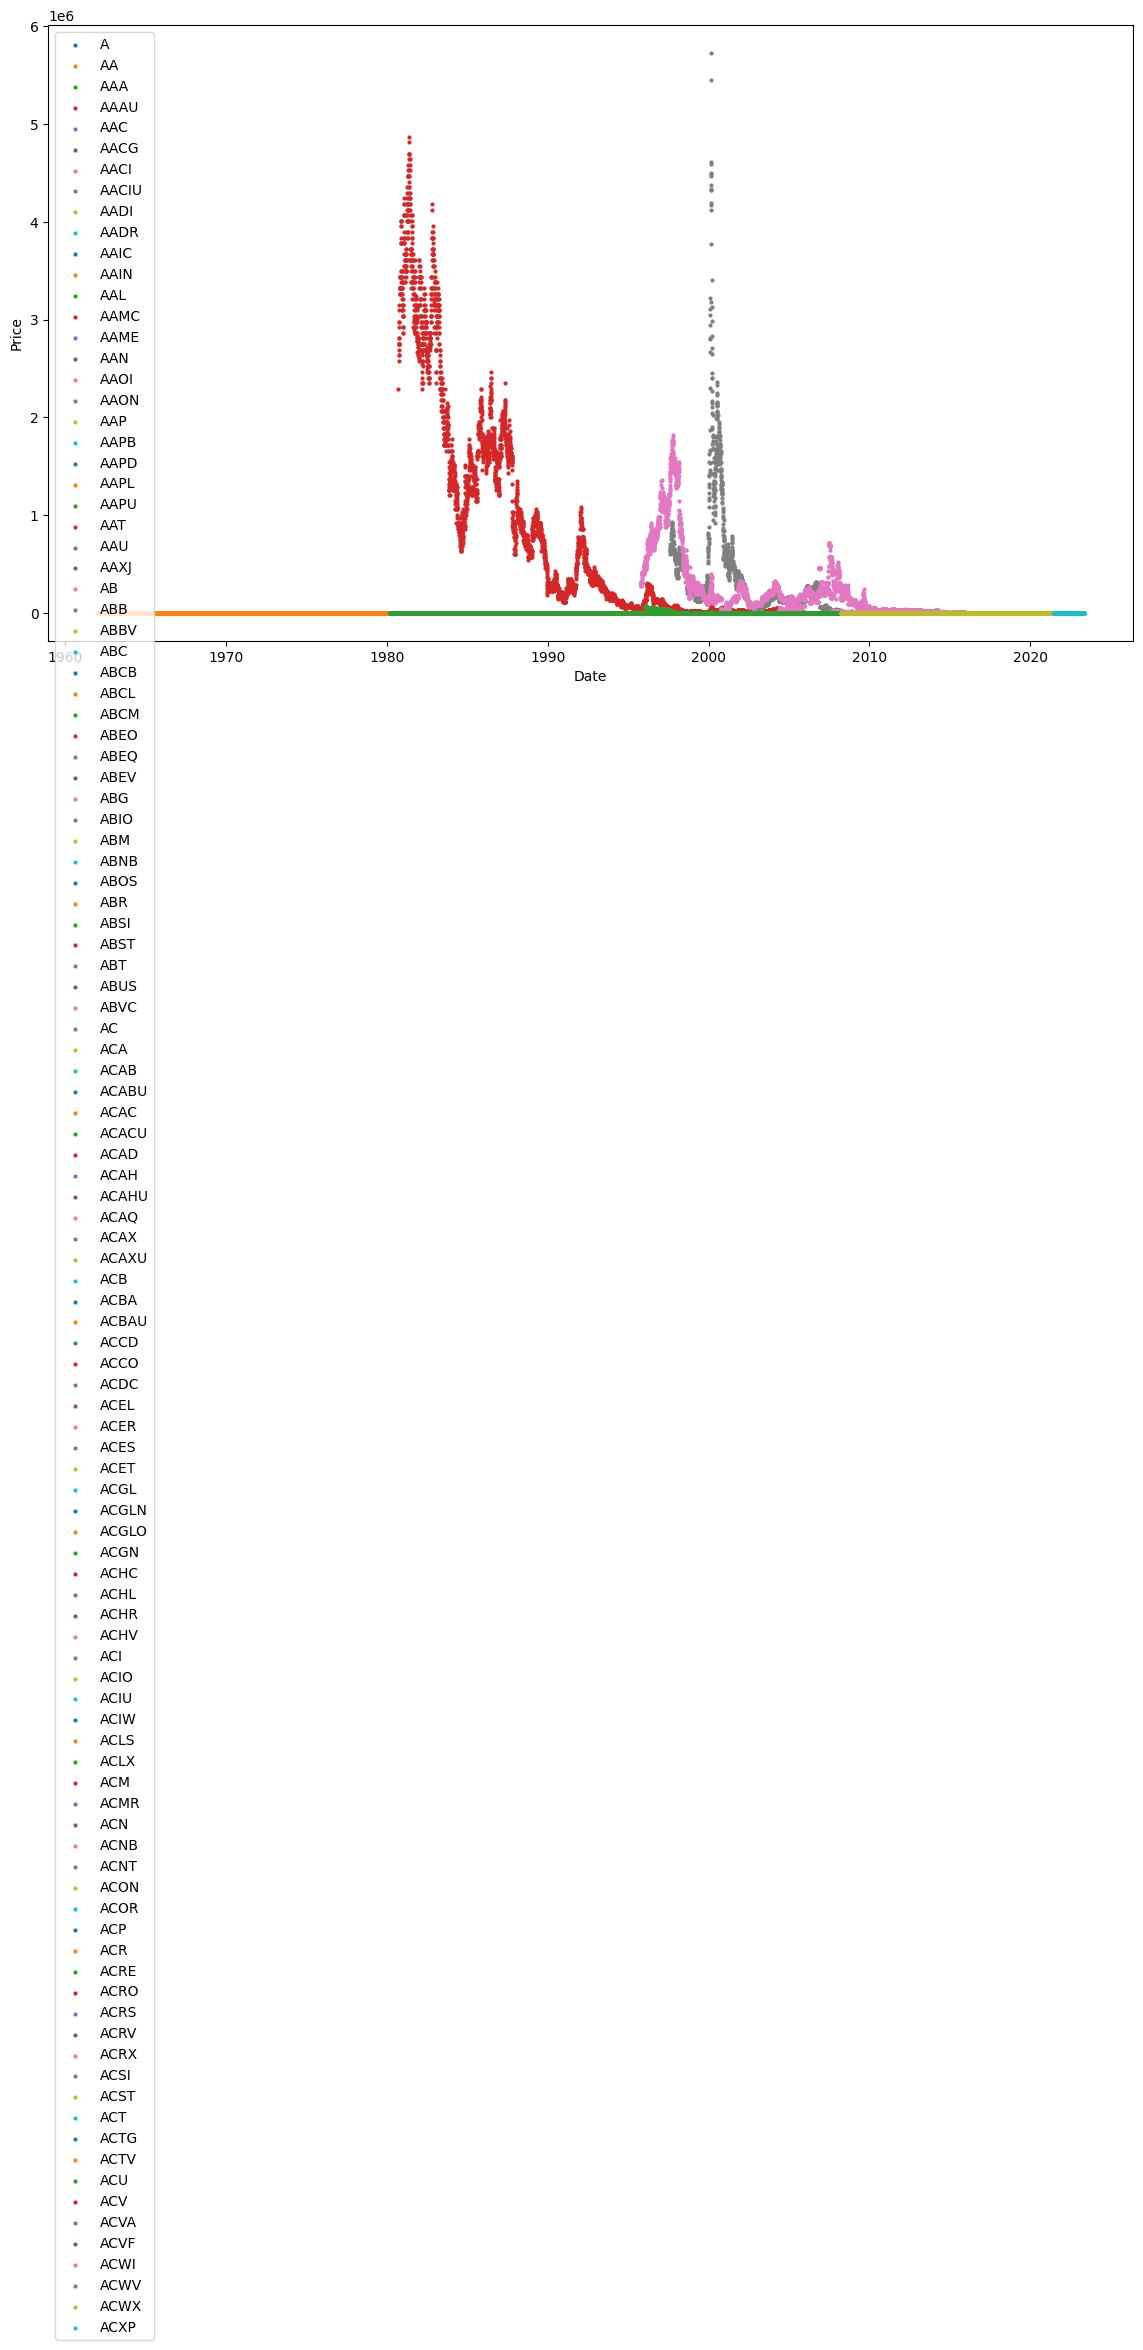

In [138]:
j=10 # for j in range(10):
plt.figure(figsize=(14, 8))
for i in range(j*10+10):
    plt.scatter(lst_dfs[i].index, lst_dfs[i]['Close'], label=lst_dfs[i]['Acronym'][0], s=4)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [135]:
df_all.describe()

,Close,Dividends,Security Type
count,3.120949e+07,3.120949e+07,3.120949e+07
mean,1.190958e+09,4.650326e-03,1.177811e+00
std,2.332712e+11,1.518322e+00,3.823537e-01
min,-6.894526e+02,0.000000e+00,1.000000e+00
25%,5.576097e+00,0.000000e+00,1.000000e+00
50%,1.502071e+01,0.000000e+00,1.000000e+00
75%,3.366400e+01,0.000000e+00,1.000000e+00
max,8.675100e+13,3.706250e+03,2.000000e+00


It's hard to see many of the stocks because the few large ones scale the graph so much. I'll try a logarithmic scale

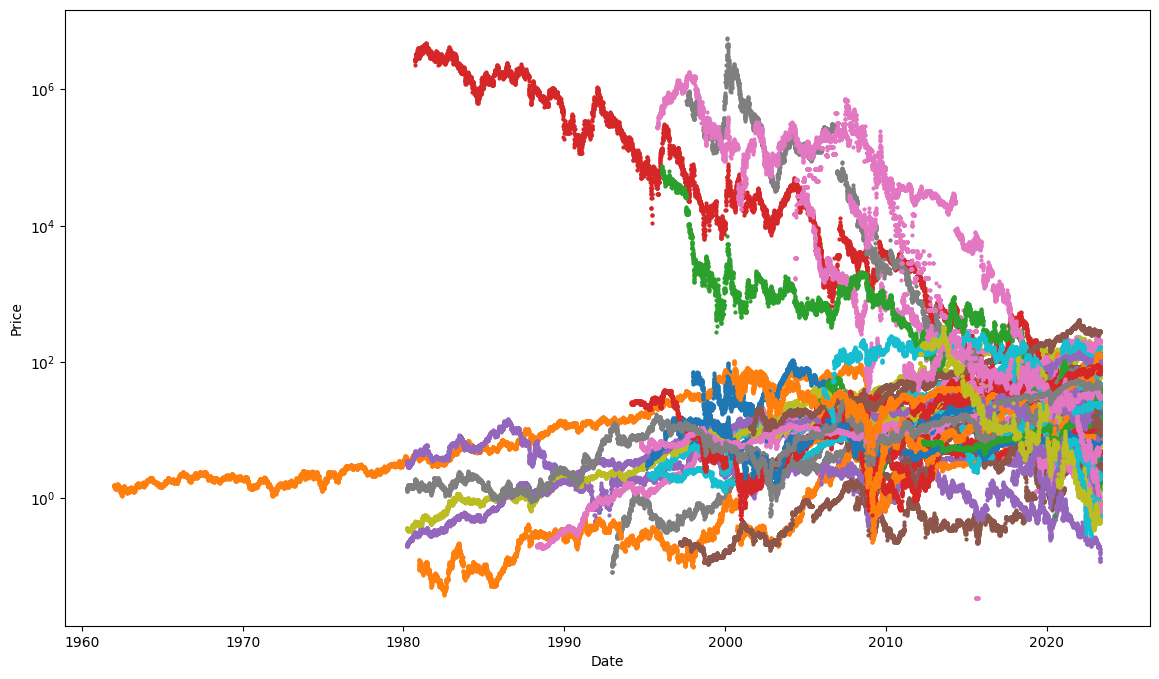

In [141]:
n = 100
plt.figure(figsize=(14, 8))
for i in range(n):
    plt.scatter(lst_dfs[i].index, lst_dfs[i]['Close'], label=lst_dfs[i]['Acronym'][0], s=4)

plt.xlabel('Date')
plt.ylabel('Price')
plt.yscale('log')
plt.show()

This is colorful but not very informative. I'll try looking at moderately large stocks

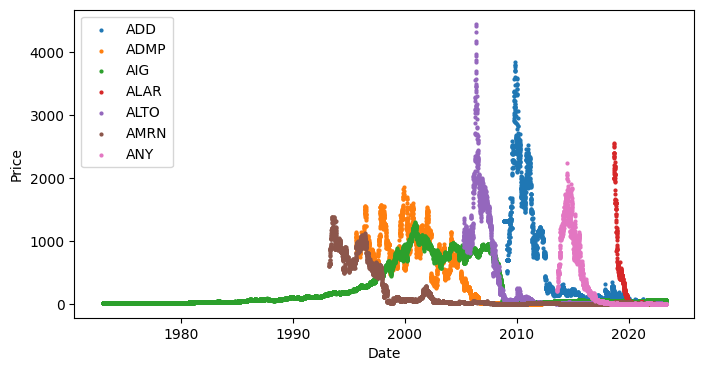

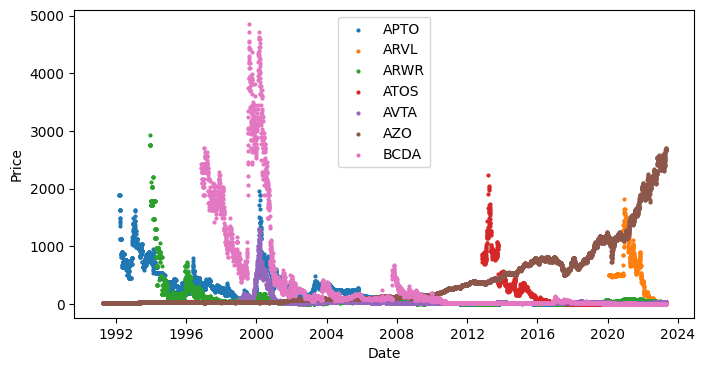

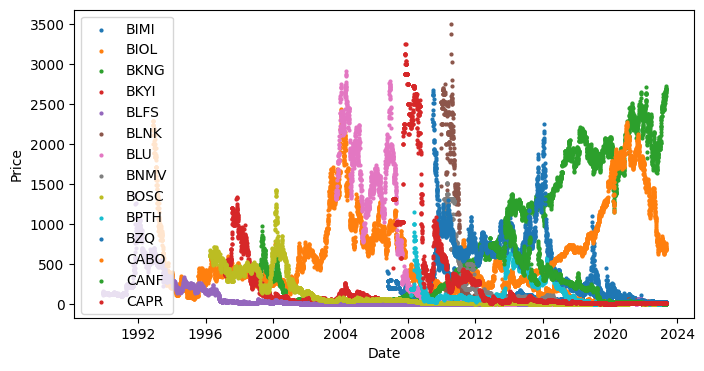

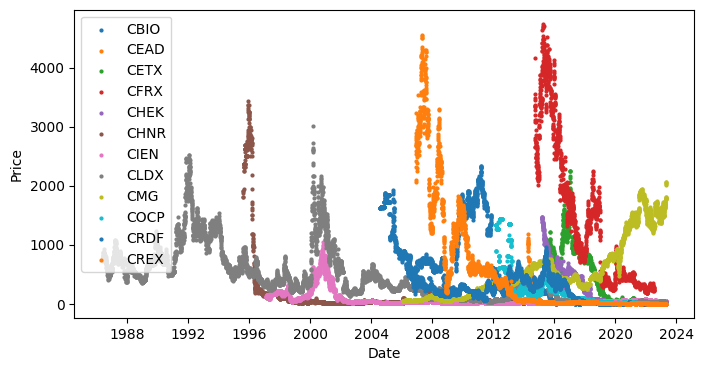

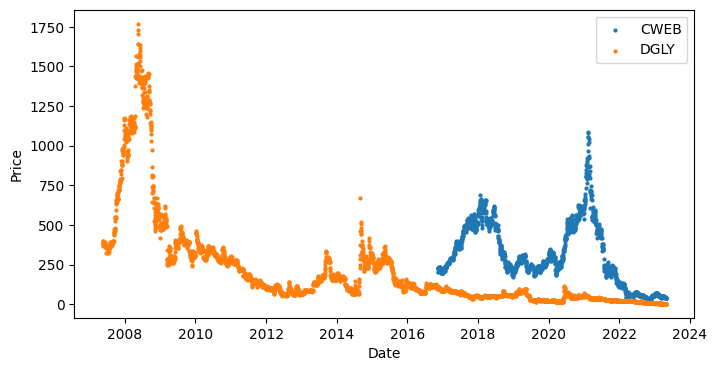

In [134]:
for j in range(5):
    n = 500
    plt.figure(figsize=(8, 4))
    for i in range(n*j, n*j+n):
        m = lst_dfs[i]['Close'].max()
        if 1000 < m < 5000:
            plt.scatter(lst_dfs[i].index, lst_dfs[i]['Close'], label=lst_dfs[i]['Acronym'][0], s=4)

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

A lot of the stocks that go far up also go back down. This doesn't appear to be reliable investment. I'll look at some of the smaller stocks

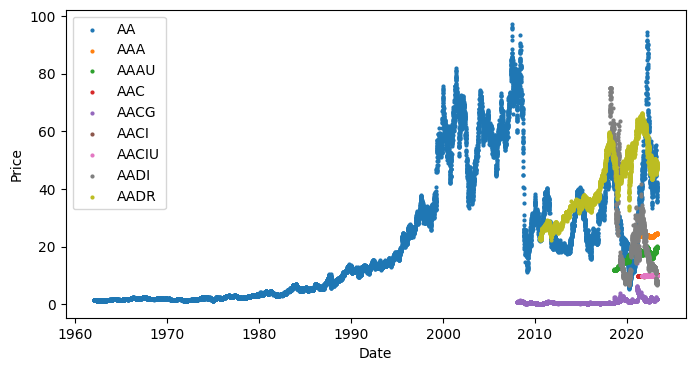

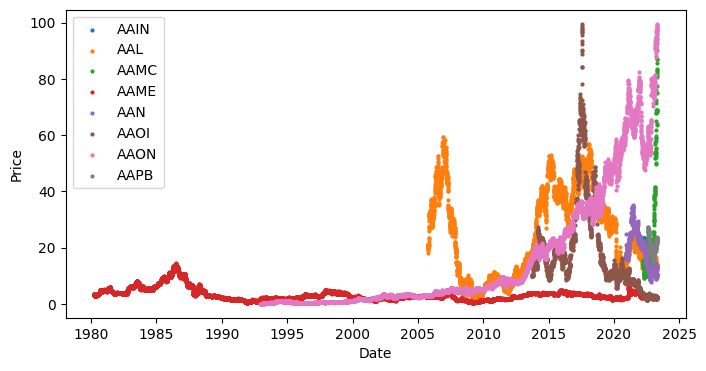

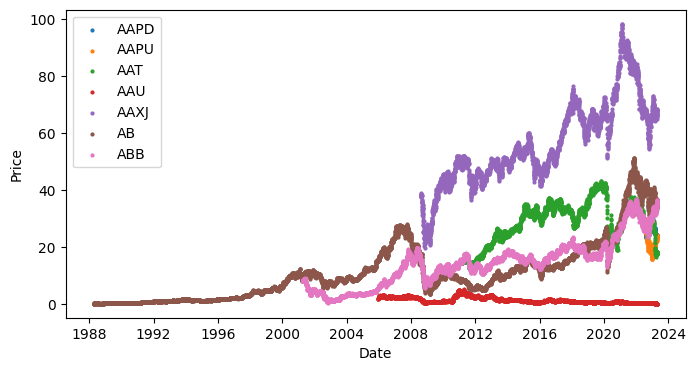

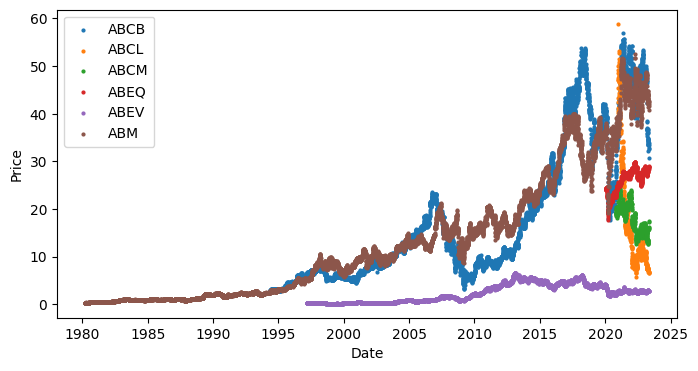

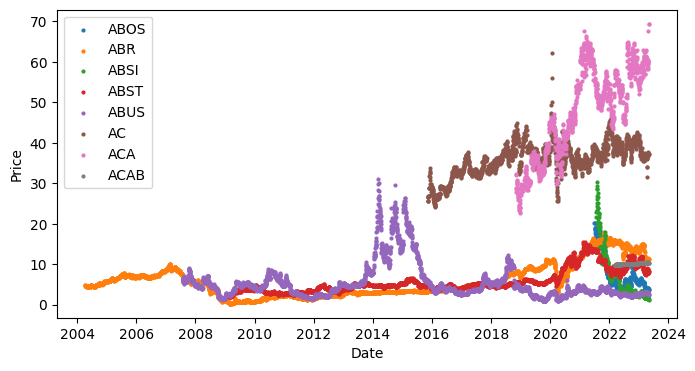

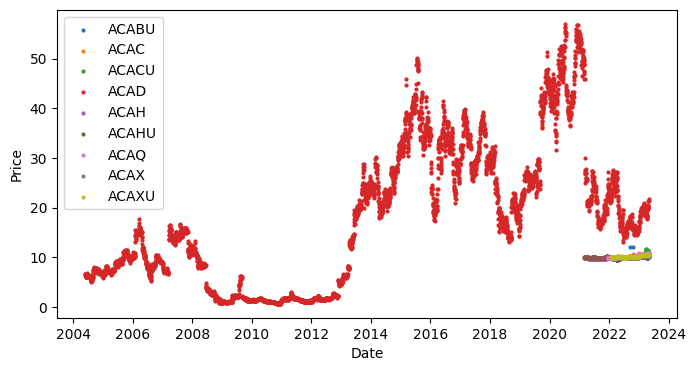

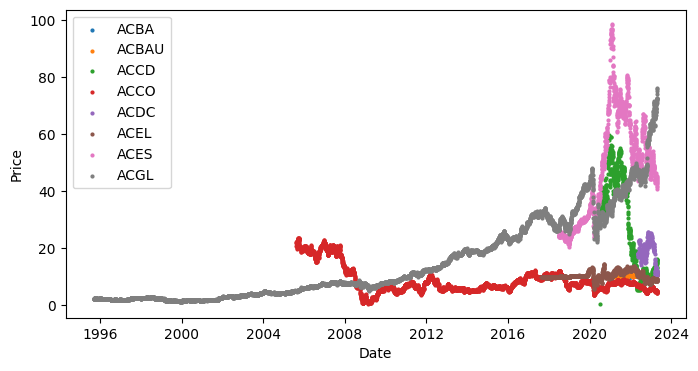

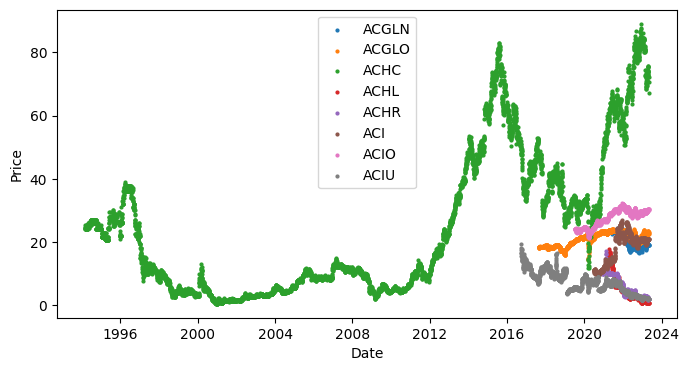

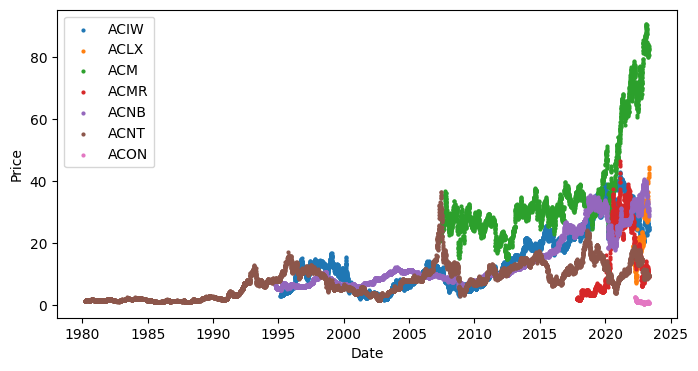

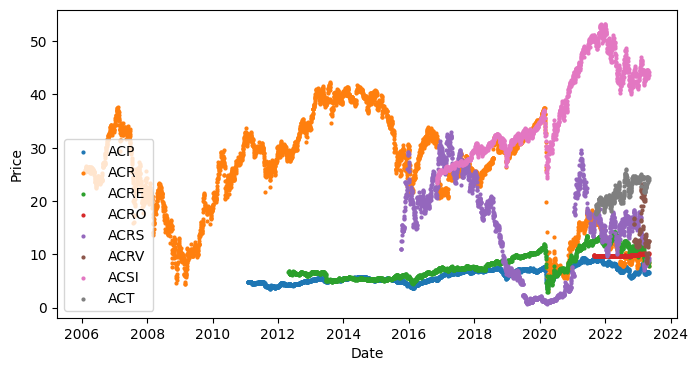

In [147]:
for j in range(10):
    plt.figure(figsize=(8, 4))
    for i in range(j*10, j*10+10):
        if lst_dfs[i]['Close'].max() < 100:
            plt.scatter(lst_dfs[i].index, lst_dfs[i]['Close'], label=lst_dfs[i]['Acronym'][0], s=4)

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

Several of those looked to have positive trends over the last few years. But it's hard to use short time spans to predict long term value. What about old stocks, that have been around for a while? 

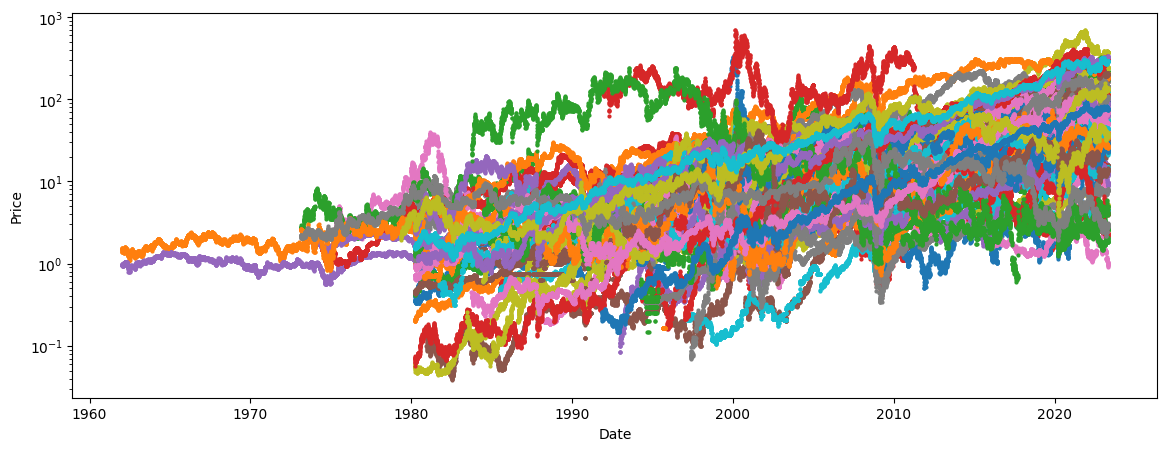

In [146]:
n = 500
plt.figure(figsize=(14, 5))
for i in range(n):
    age = min(lst_dfs[i].index[0], lst_dfs[i].index[-1])
    peak = lst_dfs[i]['Close'].max()
    if str(age) < '2000-01-01' and peak < 1000:
        plt.scatter(lst_dfs[i].index, lst_dfs[i]['Close'], label=lst_dfs[i]['Acronym'][0], s=4)

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

That's interesting. It seems to suggest a positive trend. Now I'll test that. 